# Main Results

**Notebook to reproduce results reported in the paper**: https://doi.org/10.1016/j.humimm.2022.03.010

Brunekreef TE, Reteig LC, Limper M, Haitjema S, Dias J, Mathsson-Alm L, van Laar JM, Otten HG. Microarray analysis of autoantibodies can identify future Systemic Lupus Erythematosus patients. Human Immunology. 2022 Apr 11.

## Setup

In [1]:
import os
import feather
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score

from sle.modeling import generate_data, prep_data, eval_model, calc_roc_cv, plot_roc_cv
from sle.penalization import regularization_range, choose_C
%load_ext autoreload
%autoreload 2

If you want to run the code but don't have access to the data, skip the cell below and run the following instead, to generate some synthetic data:

In [2]:
data_dir = os.path.join('..', 'data', 'processed')
data_all = feather.read_dataframe(os.path.join(data_dir, 'imid.feather'))
X_test_df = feather.read_dataframe(os.path.join(data_dir,'rest.feather'))

## Projection

See the `projection.ipynb` notebook for extended results and analyses

In [3]:
trf = PowerTransformer(method='box-cox')

In [4]:
df_combined = pd.concat([data_all, X_test_df[X_test_df.Class.isin(['preSLE', 'rest_large'])]])
df_combined['Class'] = pd.Categorical(df_combined.Class, categories = ['SLE','IMID','nonIMID','rest_large','BBD','preSLE']) # order for plotting: largest groups first
df_combined.sort_values(by='Class', inplace=True)
X_combined = np.array(df_combined.loc[:, ~df_combined.columns.isin(["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ['Class'] + ['dsDNA1'])])
X_combined_scaled = trf.fit_transform(X_combined+1)

In [5]:
X_combined.shape

(1887, 57)

In [6]:
df_combined.Class.value_counts()

SLE           483
rest_large    462
BBD           361
IMID          346
nonIMID       218
preSLE         17
Name: Class, dtype: int64

In [7]:
umap_obj = umap.UMAP(random_state=42)
Y_umap_combined = umap_obj.fit_transform(X_combined_scaled)

In [8]:
df_combined['umap_1'] = Y_umap_combined[:,0]
df_combined['umap_2'] = Y_umap_combined[:,1]

### Figure 1

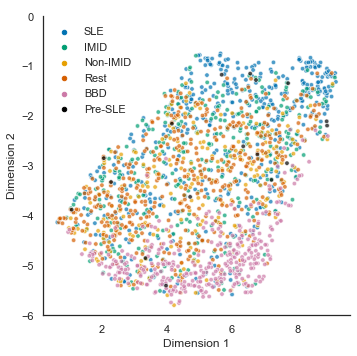

In [9]:
with sns.plotting_context("paper"):
    sns.set(font="Arial")
    sns.set_style('white')
    f, ax = plt.subplots(figsize=(5.5, 5.5))
    g = sns.scatterplot(x='umap_1',y='umap_2',
                    hue='Class', style='Class', size='Class',
                    markers = {"SLE": "o", "rest_large": "o", "BBD": "o", "IMID": "o", "nonIMID": "o", "preSLE": "o"},
                    sizes = {"SLE": 20, "rest_large": 20, "BBD": 20, "IMID": 20, "nonIMID": 20, "preSLE": 20},
                    palette={"SLE": '#0072B2', "rest_large": '#D55E00', "BBD": '#CC79A7', "IMID": '#009E73', "nonIMID": '#E69F00', "preSLE": '#000000'},
                    alpha=.7,
                    data=df_combined,
                    ax=ax)
    legend = ax.legend(frameon=False, loc = 'upper left', bbox_to_anchor=(0,1.05))
    ax.set_xlabel('Dimension 1'); ax.set_ylabel('Dimension 2'); 
    ax.set_ylim(-6,0)
    new_labels = ['','SLE','IMID','Non-IMID','Rest','BBD','Pre-SLE']; # remove legend title and change group spelling
    for t, l in zip(legend.texts, new_labels): t.set_text(l)
    sns.despine(fig=f,ax=ax)

## Prediction models

In [10]:
X_nonIMID, y_nonIMID = prep_data(data_all, 'SLE', 'nonIMID', drop_cols = ["Arthritis","Pleurisy","Pericarditis","Nefritis","dsDNA1"])
dsDNA_nonIMID = X_nonIMID.dsDNA2.values.reshape(-1,1)

In [11]:
clf = LogisticRegression(penalty = 'none', max_iter = 10000)

In [12]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=40)

### SLE vs. non-IMID

See the `SLE Versus nonIMID.ipynb` notebook for extended analyses and results

#### Logistic regression: Only dsDNA from microarray

In [13]:
lr_dsDNA_nonIMID = clf.fit(dsDNA_nonIMID, y_nonIMID)

In [14]:
np.mean(cross_val_score(clf, dsDNA_nonIMID, y_nonIMID, cv=cv, scoring = 'roc_auc'))

0.8006217102395325

#### Logistic regression: Whole microarray

In [15]:
Xp1_nonIMID = X_nonIMID + 1 # Some < 0 values > -1. Because negative fluorescence isn't possible, and Box-Cox requires strictly positive values, add ofset

In [16]:
pipe_trf = Pipeline([
        ('transform', trf),
        ('clf', clf)])

In [17]:
np.mean(cross_val_score(pipe_trf, Xp1_nonIMID, y_nonIMID, cv=cv, scoring = 'roc_auc'))

0.8337294463757692

### LASSO

In [18]:
clf_lasso = LogisticRegression(penalty='l1', max_iter = 10000, solver = 'liblinear')

In [19]:
K = 100
lambda_min, lambda_max = regularization_range(Xp1_nonIMID,y_nonIMID,trf)
Cs_lasso_nonIMID = np.logspace(np.log10(1/lambda_min),np.log10(1/lambda_max), K)
pipe = Pipeline([
        ('trf', trf),
        ('clf', clf_lasso)
])
params = [{
    "clf__C": Cs_lasso_nonIMID
}]

lasso_nonIMID = GridSearchCV(pipe, params, cv = cv, scoring = 'roc_auc', refit=choose_C)

In [20]:
%%time
lasso_nonIMID.fit(Xp1_nonIMID,y_nonIMID)

CPU times: user 3min 33s, sys: 64.1 ms, total: 3min 33s
Wall time: 3min 33s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=40),
             estimator=Pipeline(steps=[('trf',
                                        PowerTransformer(method='box-cox')),
                                       ('clf',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             param_grid=[{'clf__C': array([6.52012573, 6.08069108, 5.67087285, 5.288675  , 4.932236  ,
       4.5998198 , 4.28980735, 4.00068869, 3.73105566, 3...
       0.04932236, 0.0459982 , 0.04289807, 0.04000689, 0.03731056,
       0.03479595, 0.03245082, 0.03026374, 0.02822407, 0.02632186,
       0.02454785, 0.02289341, 0.02135047, 0.01991152, 0.01856955,
       0.01731803, 0.01615085, 0.01506234, 0.01404719, 0.01310045,
       0.01221753, 0.0113941 , 0.01062618, 0.00991001, 0.00924211,
       0.00861922

Best model AUC:

In [21]:
lasso_nonIMID.cv_results_['mean_test_score'].max()

0.8373932541974528

AUC with lambda selected through 1 SE rule:

In [22]:
lasso_nonIMID.cv_results_['mean_test_score'][lasso_nonIMID.best_index_]

0.8334140652811983

Number of non-zero coefficients in this model:

In [23]:
coefs_final_nonimid = (pd.Series(lasso_nonIMID.best_estimator_.named_steps.clf.coef_.squeeze(), 
                                 index = X_nonIMID.columns)[lambda x: x!=0].sort_values())
len(coefs_final_nonimid)

29

#### Figure 2 (top panel)

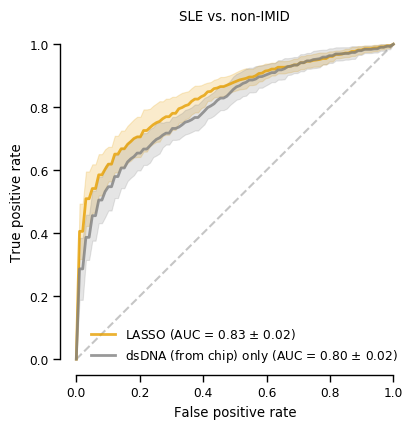

In [24]:
sns.reset_defaults()
with sns.plotting_context("paper"):
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    tprs, aucs = calc_roc_cv(lasso_nonIMID.best_estimator_,cv,Xp1_nonIMID,y_nonIMID)
    fig, ax = plot_roc_cv(tprs, aucs, fig, ax, fig_title='SLE vs. non-IMID', line_color='#E69F00', legend_label='LASSO')
    tprs, aucs = calc_roc_cv(lr_dsDNA_nonIMID,cv,dsDNA_nonIMID,y_nonIMID)
    fig, ax = plot_roc_cv(tprs, aucs, fig, ax, reuse=True, line_color='gray', legend_label='dsDNA (from chip) only')
    sns.despine(fig=fig,ax=ax, trim=True)
    plt.legend(frameon=False)
    plt.show()

#### Supplemental Figure 1a

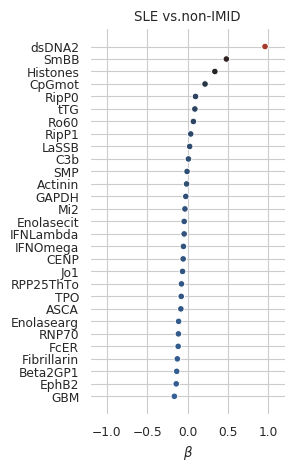

In [25]:
sns.reset_defaults()
pal = sns.diverging_palette(250, 15, s=75, l=40, center="dark", as_cmap=True)
with sns.plotting_context("paper"):
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(figsize=(2.5, 5))
        g = sns.scatterplot(y=coefs_final_nonimid.index, x=coefs_final_nonimid.values, 
                            hue=coefs_final_nonimid.values, palette=pal, legend=False)
        ax.set(title='SLE vs.non-IMID',
               xticks=np.linspace(-1.0,1.0,5), xlim=[-1.2,1.2], xlabel=r'$\beta$')
        sns.despine(fig=fig,ax=ax, left=True, bottom=True)

### SLE vs. BBD (Blood Bank Donors)

See the `SLE Versus BBD.ipynb` notebook for extended analyses and results

#### Logistic regression: Only one feature

In [26]:
X, y = prep_data(data_all, 'SLE', 'BBD', drop_cols = ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
dsDNA = X.dsDNA2.values.reshape(-1,1)
Ro60 = X.Ro60.values.reshape(-1,1)

##### dsDNA from microarray

In [27]:
lr_dsDNA = clf.fit(dsDNA, y)

In [28]:
np.mean(cross_val_score(clf, dsDNA, y, cv=cv, scoring = 'roc_auc'))

0.7956906204723647

##### Ro60 from microarray

In [29]:
np.mean(cross_val_score(clf, Ro60, y, cv=cv, scoring = 'roc_auc'))

0.8980197798817389

### LASSO

In [30]:
Xp1 = X + 1 # Some values are between -1 and 0. Because negative fluorescence isn't possible, and Box-Cox requires strictly positive values, add ofset

In [31]:
lambda_min, lambda_max = regularization_range(Xp1,y,trf)

In [32]:
K = 100
Cs_lasso = np.logspace(np.log10(1/lambda_min),np.log10(1/lambda_max), K)
pipe = Pipeline([
        ('trf', trf),
        ('clf', clf_lasso)
])
params = [{
    "clf__C": Cs_lasso
}]

search_lasso = GridSearchCV(pipe, params, cv = cv, scoring = 'roc_auc', refit=choose_C)

In [33]:
%%time
search_lasso.fit(Xp1,y)

CPU times: user 9min 2s, sys: 17min 14s, total: 26min 16s
Wall time: 4min 36s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=40),
             estimator=Pipeline(steps=[('trf',
                                        PowerTransformer(method='box-cox')),
                                       ('clf',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             param_grid=[{'clf__C': array([3.42342671, 3.19269921, 2.97752197, 2.77684695, 2.58969676,
       2.41515987, 2.25238618, 2.10058289, 1.95901...
       0.02589697, 0.0241516 , 0.02252386, 0.02100583, 0.01959011,
       0.0182698 , 0.01703848, 0.01589014, 0.0148192 , 0.01382043,
       0.01288898, 0.01202031, 0.01121018, 0.01045465, 0.00975004,
       0.00909292, 0.00848009, 0.00790856, 0.00737555, 0.00687846,
       0.00641488, 0.00598254, 0.00557933, 0.0052033 , 0.00485262,
       0.00452557, 0.00

Best model AUC:

In [34]:
search_lasso.cv_results_['mean_test_score'].max()

0.9829972773711079

AUC with lambda selected through 1 SE rule:

In [35]:
search_lasso.cv_results_['mean_test_score'][search_lasso.best_index_]

0.9813334155499589

Number of non-zero coefficients in this model:

In [36]:
coefs_final = (pd.Series(search_lasso.best_estimator_.named_steps.clf.coef_.squeeze(), 
                                 index = X_nonIMID.columns)[lambda x: x!=0].sort_values())
len(coefs_final)

15

#### Figure 2 (bottom panel)

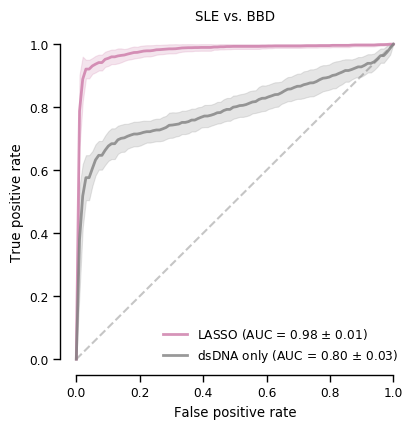

In [37]:
sns.reset_defaults()
with sns.plotting_context("paper"):
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    tprs, aucs = calc_roc_cv(search_lasso.best_estimator_,cv,Xp1,y)
    fig, ax = plot_roc_cv(tprs, aucs, fig, ax, fig_title='SLE vs. BBD', line_color='#CC79A7', legend_label='LASSO')
    tprs, aucs = calc_roc_cv(lr_dsDNA,cv,dsDNA,y)
    fig, ax = plot_roc_cv(tprs, aucs, fig, ax, reuse=True, line_color='gray', legend_label='dsDNA only')
    sns.despine(fig=fig,ax=ax, trim=True)
    plt.legend(frameon=False)
    plt.show()

#### Supplemental Figure 1b

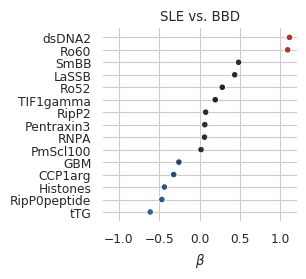

In [38]:
sns.reset_defaults()
pal = sns.diverging_palette(250, 15, s=75, l=40, center="dark", as_cmap=True)
with sns.plotting_context("paper"):
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(figsize=(2.5, 2.5))
        g = sns.scatterplot(y=coefs_final.index, x=coefs_final.values, 
                            hue=coefs_final.values, palette=pal, legend=False)
        ax.set(title='SLE vs. BBD',
               xticks=np.linspace(-1.0,1.0,5), xlim=[-1.2,1.2], xlabel=r'$\beta$')
        sns.despine(fig=fig,ax=ax, left=True, bottom=True)

## Prediction of the development of SLE

ROC AUC of SLE vs. BBD model 

In [39]:
X_test, y_test = prep_data(X_test_df, 'preSLE', 'rest_large', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
roc_auc_score(y_test, search_lasso.predict_proba(X_test+1)[:,1])

0.5679908326967151

### Figure 3

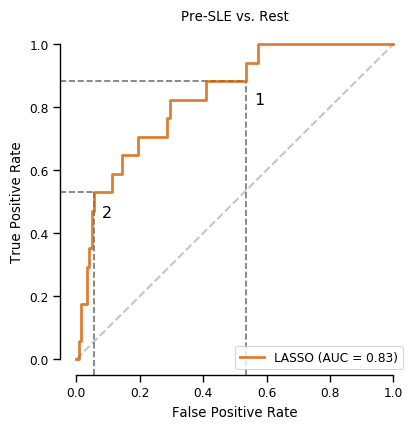

In [40]:
X_test, y_test = prep_data(X_test_df, 'preSLE', 'rest_large', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
# ROC curve
threshold1=0.5
threshold2=0.84
fpr, tpr, thresholds = roc_curve(y_test, lasso_nonIMID.predict_proba(X_test+1)[:,1])
thr_idx1 = (np.abs(thresholds - threshold1)).argmin() # find index of value closest to chosen threshold
thr_idx2 = (np.abs(thresholds - threshold2)).argmin() # find index of value closest to chosen threshold
sns.reset_defaults()
with sns.plotting_context("paper"):
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='k', alpha=.25)
    ax.set(title="Pre-SLE vs. Rest",
           xlim=[-0.05, 1.05], xlabel='False positive rate', 
           ylim=[-0.05, 1.05], ylabel='True positive rate')
    ymin, ymax = ax.get_ylim(); xmin, xmax = ax.get_xlim()
    plt.vlines(x=fpr[thr_idx1], ymin=ymin, ymax=tpr[thr_idx1], color='k', alpha=.6, linestyle='--', axes=ax) # plot line for fpr at threshold
    plt.hlines(y=tpr[thr_idx1], xmin=xmin, xmax=fpr[thr_idx1], color='k', alpha=.6, linestyle='--', axes=ax) # plot line for tpr at threshold
    plt.vlines(x=fpr[thr_idx2], ymin=ymin, ymax=tpr[thr_idx2], color='k', alpha=.6, linestyle='--', axes=ax) # plot line for fpr at threshold
    plt.hlines(y=tpr[thr_idx2], xmin=xmin, xmax=fpr[thr_idx2], color='k', alpha=.6,  linestyle='--', axes=ax) # plot line for tpr at threshold
    plot_roc_curve(lasso_nonIMID, X_test+1, y_test, name = "LASSO", ax=ax, color='#D55E00', lw=2, alpha=.8)
    plt.text(0.56,0.81, '1', fontsize='large')
    plt.text(0.08,0.45, '2', fontsize='large')
    sns.despine(fig=fig,ax=ax, trim=True)

### Classification

#### pre-SLE vs. rest, default threshold

Threshold for classification: 0.5
              precision    recall  f1-score   support

  rest_large       0.99      0.51      0.67       462
      preSLE       0.06      0.88      0.12        17

    accuracy                           0.52       479
   macro avg       0.53      0.70      0.39       479
weighted avg       0.96      0.52      0.65       479

N.B.: "recall" = sensitivity for the group in this row (e.g. preSLE); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. preSLE); NPV for the other group (rest_large)



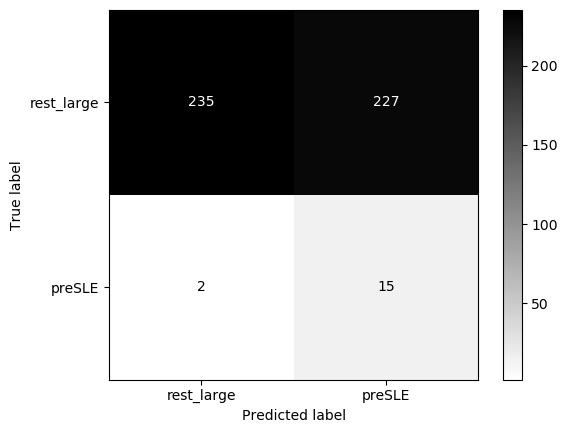

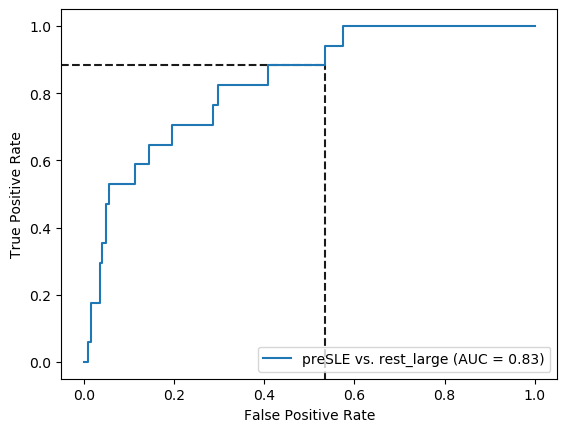

In [41]:
X_test, y_test = prep_data(X_test_df, 'preSLE', 'rest_large', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
eval_model(lasso_nonIMID, X_test+1, y_test, 'preSLE', 'rest_large')

#### pre-SLE vs. rest, high-specificity threshold

Threshold for classification: 0.84
              precision    recall  f1-score   support

  rest_large       0.98      0.94      0.96       462
      preSLE       0.25      0.53      0.34        17

    accuracy                           0.93       479
   macro avg       0.62      0.74      0.65       479
weighted avg       0.96      0.93      0.94       479

N.B.: "recall" = sensitivity for the group in this row (e.g. preSLE); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. preSLE); NPV for the other group (rest_large)



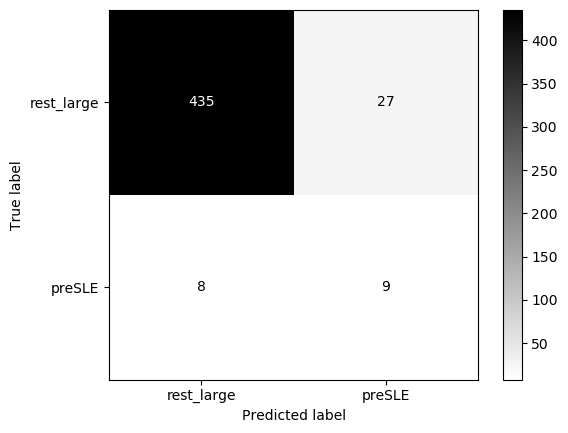

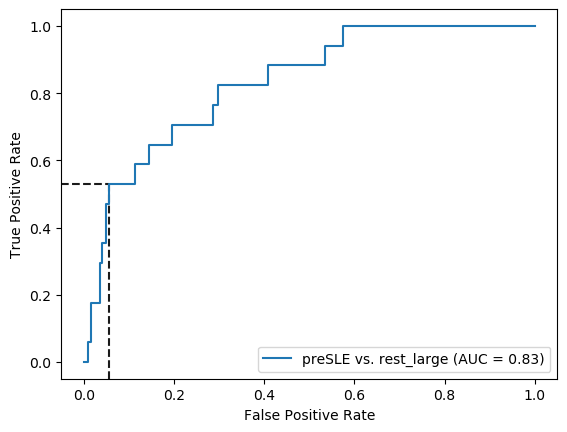

In [42]:
X_test, y_test = prep_data(X_test_df, 'preSLE', 'rest_large', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
eval_model(lasso_nonIMID, X_test+1, y_test, 'preSLE', 'rest_large', threshold=0.84)